# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [32]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

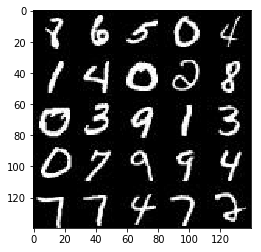

In [33]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

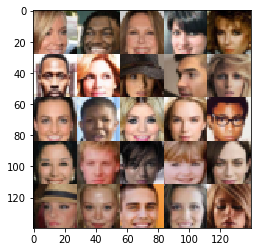

In [34]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [35]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0


/Users/victor/virtualenvlist/mydlp2/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [36]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real =  tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="input_real")
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [37]:
def leaky_relu(x, alpha):
    return tf.maximum(x * alpha, x)

### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

GAN网络的建议和技巧： https://github.com/soumith/ganhacks

In [38]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # 用tf.contrib.layers.xavier_initializer()作为kernel_initializerparameter,这样可以加快训练的收敛。
    kinitializer = tf.contrib.layers.xavier_initializer()
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28 * 28 * (1或者3)
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=kinitializer)  # 14 * 14 * 64
        relu1 = leaky_relu(x1, alpha)
        x1 = tf.nn.dropout(relu1, keep_prob=0.3)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', kernel_initializer=kinitializer)  # 7 * 7 * 128
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = leaky_relu(bn2, alpha)
        x2 = tf.nn.dropout(relu2, keep_prob=0.3)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', kernel_initializer=kinitializer)  # 4 * 4 * 256
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = leaky_relu(bn3, alpha)
        x3 = tf.nn.dropout(relu3, keep_prob=0.3)
        
        # flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1) 
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [39]:
def generator(z, out_channel_dim, is_train=True, reuse=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    kinitializer = tf.contrib.layers.xavier_initializer()
    alpha = 0.2
    with tf.variable_scope('generator', reuse=(not is_train)):
        x = tf.layers.dense(z, 7*7*1024)
        x = tf.reshape(x, (-1, 7, 7, 1024))
        x = leaky_relu(x, alpha)
        x = tf.layers.batch_normalization(x, training=is_train)
        # 7x7x1024
        
        x1 = tf.layers.conv2d_transpose(x, 256, 5, strides=2, kernel_initializer=kinitializer, padding='same')
        x1 = leaky_relu(x1, alpha)
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        # 14x14x256
        
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, kernel_initializer=kinitializer, padding='same')
        x2 = leaky_relu(x2, alpha)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        # 28x28x64
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 3, strides=1, kernel_initializer=kinitializer, padding='same')
        # 28x28x3
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [40]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [41]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [42]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [43]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_optimizer, g_optimizer = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        iteration = 0
        for epoch_i in range(epoch_count):
            batches_generator = get_batches(batch_size)
            for batch_images in batches_generator:
                # TODO: Train Model
                z_ = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                # update discriminator
                _ = sess.run(d_optimizer, feed_dict={inputs_real:batch_images*2, inputs_z:z_})
                
                # update generator 
                _ = sess.run(g_optimizer, feed_dict={inputs_z:z_, inputs_real:batch_images,})
                
                iteration += 1
                
                # calculate the loss
                if iteration % 10 == 0:
                    d_loss_ = d_loss.eval({inputs_z:z_, inputs_real:batch_images})
                    g_loss_ = g_loss.eval({inputs_z:z_})

                    print("Iteration: {}, d_loss_={:.5f}, g_loss_={:.5f}".format(iteration, d_loss_, g_loss_))
                    
                if iteration % 50 == 0: 
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)
    

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Iteration: 10, d_loss_=1.04598, g_loss_=1.82044
Iteration: 20, d_loss_=0.78995, g_loss_=2.53714
Iteration: 30, d_loss_=0.58273, g_loss_=3.17402
Iteration: 40, d_loss_=0.71664, g_loss_=3.72864
Iteration: 50, d_loss_=0.64665, g_loss_=3.40741


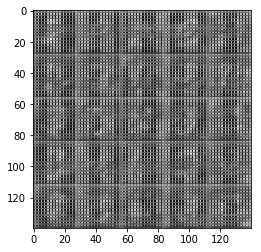

Iteration: 60, d_loss_=0.68635, g_loss_=3.06340
Iteration: 70, d_loss_=0.81238, g_loss_=3.12555
Iteration: 80, d_loss_=0.85104, g_loss_=2.86869
Iteration: 90, d_loss_=0.99224, g_loss_=2.04015
Iteration: 100, d_loss_=1.24506, g_loss_=1.22362


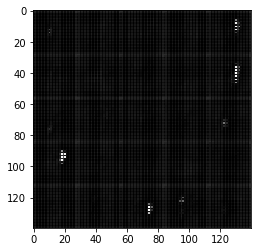

Iteration: 110, d_loss_=1.49741, g_loss_=1.58817
Iteration: 120, d_loss_=2.75258, g_loss_=0.55168
Iteration: 130, d_loss_=3.07107, g_loss_=2.45152
Iteration: 140, d_loss_=2.25753, g_loss_=1.12928
Iteration: 150, d_loss_=2.54081, g_loss_=1.40492


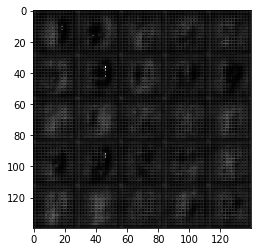

Iteration: 160, d_loss_=2.75576, g_loss_=1.17375
Iteration: 170, d_loss_=2.43739, g_loss_=1.13463
Iteration: 180, d_loss_=2.70484, g_loss_=1.77288
Iteration: 190, d_loss_=2.37351, g_loss_=1.32864
Iteration: 200, d_loss_=2.37516, g_loss_=1.01658


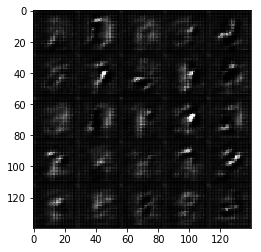

Iteration: 210, d_loss_=2.23157, g_loss_=1.26477
Iteration: 220, d_loss_=2.25323, g_loss_=0.99126
Iteration: 230, d_loss_=2.36967, g_loss_=1.21854
Iteration: 240, d_loss_=2.38361, g_loss_=1.21104
Iteration: 250, d_loss_=2.21827, g_loss_=1.00570


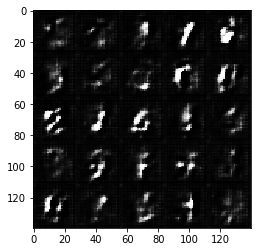

Iteration: 260, d_loss_=2.32114, g_loss_=1.01370
Iteration: 270, d_loss_=2.05534, g_loss_=1.00810
Iteration: 280, d_loss_=2.25752, g_loss_=1.12975
Iteration: 290, d_loss_=2.10302, g_loss_=1.15248
Iteration: 300, d_loss_=2.35445, g_loss_=0.95891


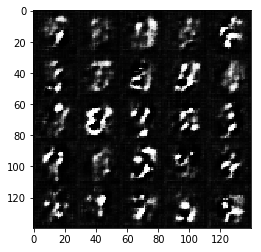

Iteration: 310, d_loss_=2.15887, g_loss_=1.08887
Iteration: 320, d_loss_=2.52780, g_loss_=1.24704
Iteration: 330, d_loss_=2.23922, g_loss_=0.92979
Iteration: 340, d_loss_=2.31509, g_loss_=1.05965
Iteration: 350, d_loss_=2.32336, g_loss_=1.07344


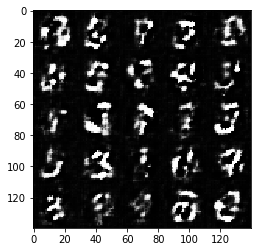

Iteration: 360, d_loss_=2.18600, g_loss_=1.01322
Iteration: 370, d_loss_=2.11431, g_loss_=1.04517
Iteration: 380, d_loss_=2.40895, g_loss_=1.07336
Iteration: 390, d_loss_=2.19881, g_loss_=0.88742
Iteration: 400, d_loss_=2.06895, g_loss_=0.88158


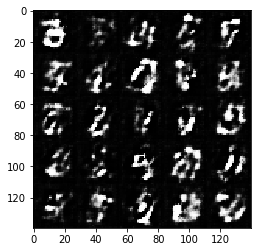

Iteration: 410, d_loss_=2.32789, g_loss_=0.96784
Iteration: 420, d_loss_=2.21423, g_loss_=0.99030
Iteration: 430, d_loss_=2.16776, g_loss_=0.93633
Iteration: 440, d_loss_=2.12891, g_loss_=0.90449
Iteration: 450, d_loss_=2.07962, g_loss_=0.91601


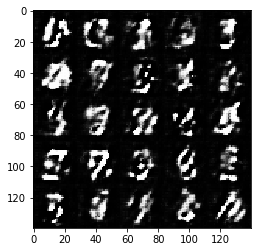

Iteration: 460, d_loss_=2.03808, g_loss_=0.96117
Iteration: 470, d_loss_=2.11847, g_loss_=0.89912
Iteration: 480, d_loss_=2.14564, g_loss_=0.90686
Iteration: 490, d_loss_=2.14787, g_loss_=0.86601
Iteration: 500, d_loss_=2.07291, g_loss_=0.98880


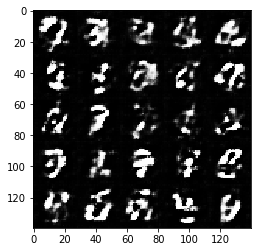

Iteration: 510, d_loss_=2.13641, g_loss_=0.94859
Iteration: 520, d_loss_=2.04684, g_loss_=0.97807
Iteration: 530, d_loss_=2.07946, g_loss_=0.94677
Iteration: 540, d_loss_=2.06632, g_loss_=0.97404
Iteration: 550, d_loss_=2.12389, g_loss_=0.90173


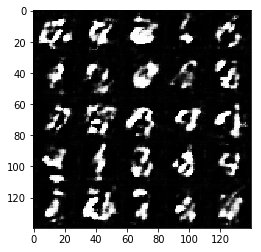

Iteration: 560, d_loss_=2.09763, g_loss_=0.92345
Iteration: 570, d_loss_=2.12119, g_loss_=1.01348
Iteration: 580, d_loss_=1.98259, g_loss_=0.85075
Iteration: 590, d_loss_=1.98686, g_loss_=0.88828
Iteration: 600, d_loss_=2.04921, g_loss_=0.94647


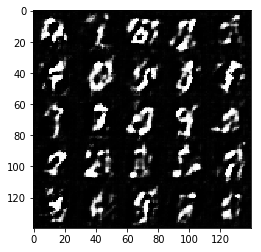

Iteration: 610, d_loss_=2.04314, g_loss_=1.02677
Iteration: 620, d_loss_=2.12151, g_loss_=1.02867
Iteration: 630, d_loss_=2.03203, g_loss_=0.87882
Iteration: 640, d_loss_=2.01373, g_loss_=0.97587
Iteration: 650, d_loss_=2.12410, g_loss_=0.86963


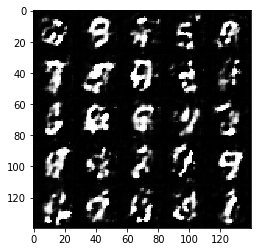

Iteration: 660, d_loss_=2.05082, g_loss_=0.76645
Iteration: 670, d_loss_=1.98637, g_loss_=0.88464
Iteration: 680, d_loss_=2.03561, g_loss_=0.91175
Iteration: 690, d_loss_=2.03180, g_loss_=1.00118
Iteration: 700, d_loss_=2.08828, g_loss_=0.85719


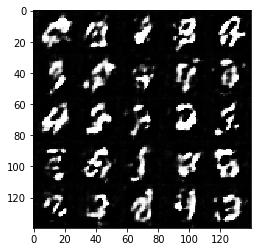

Iteration: 710, d_loss_=1.98571, g_loss_=0.94577
Iteration: 720, d_loss_=2.07453, g_loss_=0.95347
Iteration: 730, d_loss_=1.96464, g_loss_=0.89979
Iteration: 740, d_loss_=2.09016, g_loss_=0.93897
Iteration: 750, d_loss_=2.03370, g_loss_=0.92537


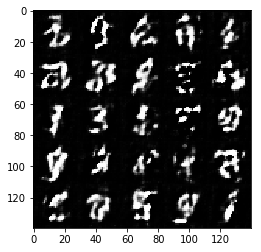

Iteration: 760, d_loss_=1.94898, g_loss_=0.95370
Iteration: 770, d_loss_=2.06469, g_loss_=0.96597
Iteration: 780, d_loss_=2.12406, g_loss_=0.96821
Iteration: 790, d_loss_=2.03198, g_loss_=0.91484
Iteration: 800, d_loss_=2.08279, g_loss_=0.96933


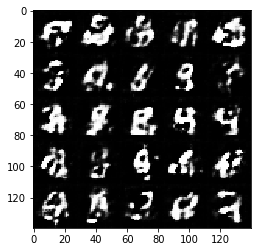

Iteration: 810, d_loss_=2.09722, g_loss_=0.94892
Iteration: 820, d_loss_=2.07960, g_loss_=0.92786
Iteration: 830, d_loss_=2.05073, g_loss_=0.95290
Iteration: 840, d_loss_=2.03471, g_loss_=0.91301
Iteration: 850, d_loss_=2.08180, g_loss_=0.90576


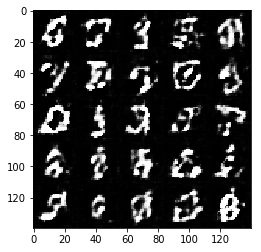

Iteration: 860, d_loss_=2.08936, g_loss_=0.96773
Iteration: 870, d_loss_=2.14004, g_loss_=0.96104
Iteration: 880, d_loss_=1.97150, g_loss_=0.85895
Iteration: 890, d_loss_=2.04146, g_loss_=0.84281
Iteration: 900, d_loss_=2.07076, g_loss_=0.81890


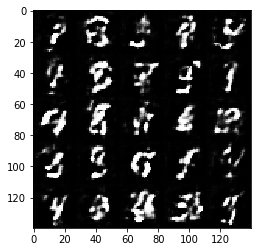

Iteration: 910, d_loss_=2.06938, g_loss_=0.95426
Iteration: 920, d_loss_=2.08284, g_loss_=0.86031
Iteration: 930, d_loss_=2.15865, g_loss_=0.79715


In [44]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Iteration: 10, d_loss_=1.44996, g_loss_=1.38387
Iteration: 20, d_loss_=1.53307, g_loss_=1.66937
Iteration: 30, d_loss_=1.11204, g_loss_=2.14527
Iteration: 40, d_loss_=0.89886, g_loss_=2.32512
Iteration: 50, d_loss_=0.78950, g_loss_=2.66366


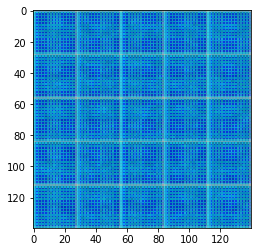

Iteration: 60, d_loss_=0.67427, g_loss_=3.49849
Iteration: 70, d_loss_=0.71971, g_loss_=3.13519
Iteration: 80, d_loss_=0.69771, g_loss_=3.26748
Iteration: 90, d_loss_=0.61762, g_loss_=3.42943
Iteration: 100, d_loss_=0.59189, g_loss_=3.52078


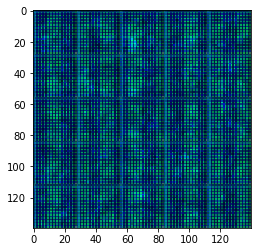

Iteration: 110, d_loss_=0.58330, g_loss_=3.80673
Iteration: 120, d_loss_=0.69970, g_loss_=2.91018
Iteration: 130, d_loss_=0.58389, g_loss_=3.76590
Iteration: 140, d_loss_=0.61655, g_loss_=3.78546
Iteration: 150, d_loss_=0.76522, g_loss_=3.43509


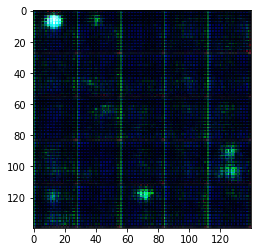

Iteration: 160, d_loss_=0.74088, g_loss_=3.99603
Iteration: 170, d_loss_=0.95033, g_loss_=3.18505
Iteration: 180, d_loss_=0.90909, g_loss_=3.36793
Iteration: 190, d_loss_=0.92798, g_loss_=4.13238
Iteration: 200, d_loss_=0.96906, g_loss_=3.75557


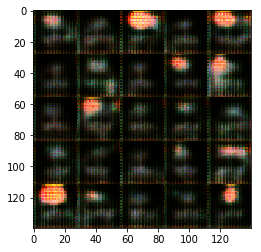

Iteration: 210, d_loss_=0.81854, g_loss_=3.74589
Iteration: 220, d_loss_=2.31720, g_loss_=0.82125
Iteration: 230, d_loss_=1.41537, g_loss_=2.06338
Iteration: 240, d_loss_=1.05280, g_loss_=2.74276
Iteration: 250, d_loss_=0.86169, g_loss_=3.61711


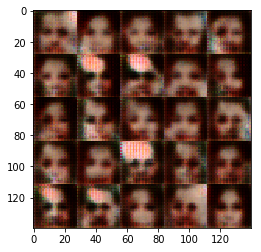

Iteration: 260, d_loss_=1.35375, g_loss_=2.01285
Iteration: 270, d_loss_=1.04901, g_loss_=2.61697
Iteration: 280, d_loss_=1.17603, g_loss_=2.44007
Iteration: 290, d_loss_=1.26614, g_loss_=2.06731
Iteration: 300, d_loss_=1.60483, g_loss_=1.42251


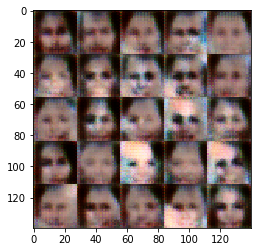

Iteration: 310, d_loss_=1.03840, g_loss_=1.97067
Iteration: 320, d_loss_=1.39707, g_loss_=1.04777
Iteration: 330, d_loss_=1.41327, g_loss_=1.33851
Iteration: 340, d_loss_=1.40332, g_loss_=0.97520
Iteration: 350, d_loss_=1.20753, g_loss_=1.05861


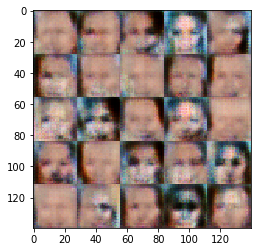

Iteration: 360, d_loss_=1.01674, g_loss_=1.28885
Iteration: 370, d_loss_=1.21710, g_loss_=0.98866
Iteration: 380, d_loss_=1.31089, g_loss_=0.88633
Iteration: 390, d_loss_=1.24707, g_loss_=0.84950
Iteration: 400, d_loss_=1.24131, g_loss_=1.17921


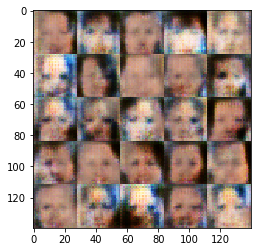

Iteration: 410, d_loss_=1.23582, g_loss_=1.06928
Iteration: 420, d_loss_=1.31902, g_loss_=1.03317
Iteration: 430, d_loss_=1.38892, g_loss_=0.90405
Iteration: 440, d_loss_=1.20314, g_loss_=1.05161
Iteration: 450, d_loss_=1.29418, g_loss_=1.06471


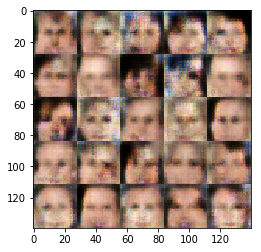

Iteration: 460, d_loss_=1.39863, g_loss_=0.94628
Iteration: 470, d_loss_=1.47764, g_loss_=0.96976
Iteration: 480, d_loss_=1.43884, g_loss_=0.94539
Iteration: 490, d_loss_=1.55414, g_loss_=0.92066
Iteration: 500, d_loss_=1.41824, g_loss_=0.96317


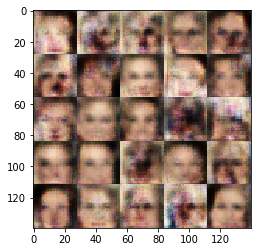

Iteration: 510, d_loss_=1.49228, g_loss_=0.88548
Iteration: 520, d_loss_=1.52443, g_loss_=0.95521
Iteration: 530, d_loss_=1.56512, g_loss_=0.84281
Iteration: 540, d_loss_=1.47695, g_loss_=1.02814
Iteration: 550, d_loss_=1.60856, g_loss_=0.92651


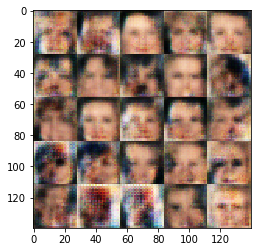

Iteration: 560, d_loss_=1.48385, g_loss_=0.87555
Iteration: 570, d_loss_=1.43922, g_loss_=0.88755
Iteration: 580, d_loss_=1.53433, g_loss_=0.94257
Iteration: 590, d_loss_=1.43724, g_loss_=0.94382
Iteration: 600, d_loss_=1.39317, g_loss_=1.03747


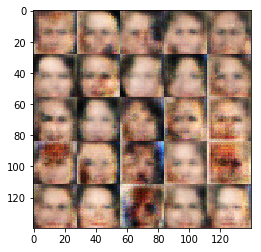

Iteration: 610, d_loss_=1.57690, g_loss_=0.83665
Iteration: 620, d_loss_=1.45916, g_loss_=0.84099
Iteration: 630, d_loss_=1.43596, g_loss_=0.93635
Iteration: 640, d_loss_=1.54317, g_loss_=0.96482
Iteration: 650, d_loss_=1.51851, g_loss_=0.92105


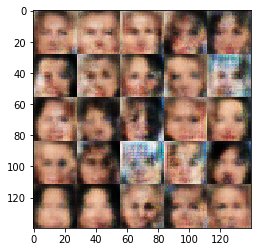

Iteration: 660, d_loss_=1.42900, g_loss_=0.89674
Iteration: 670, d_loss_=1.40648, g_loss_=0.92089
Iteration: 680, d_loss_=1.50424, g_loss_=0.85380
Iteration: 690, d_loss_=1.46686, g_loss_=0.94539
Iteration: 700, d_loss_=1.48870, g_loss_=0.87546


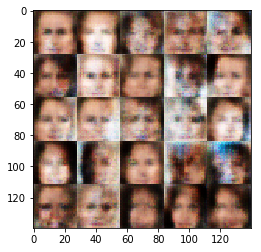

Iteration: 710, d_loss_=1.63294, g_loss_=0.85899
Iteration: 720, d_loss_=1.49783, g_loss_=0.87054
Iteration: 730, d_loss_=1.49433, g_loss_=0.82535
Iteration: 740, d_loss_=1.52011, g_loss_=0.86575
Iteration: 750, d_loss_=1.49212, g_loss_=0.91875


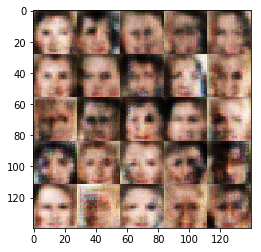

Iteration: 760, d_loss_=1.53019, g_loss_=0.90741
Iteration: 770, d_loss_=1.49620, g_loss_=0.94741
Iteration: 780, d_loss_=1.50509, g_loss_=0.90846
Iteration: 790, d_loss_=1.54838, g_loss_=0.85989
Iteration: 800, d_loss_=1.52783, g_loss_=0.88350


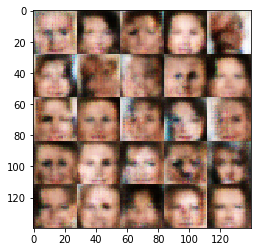

Iteration: 810, d_loss_=1.46350, g_loss_=0.87724
Iteration: 820, d_loss_=1.51673, g_loss_=0.84133
Iteration: 830, d_loss_=1.46206, g_loss_=0.91854
Iteration: 840, d_loss_=1.46538, g_loss_=0.94015
Iteration: 850, d_loss_=1.56311, g_loss_=0.90021


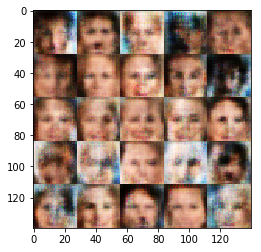

Iteration: 860, d_loss_=1.43259, g_loss_=0.91706
Iteration: 870, d_loss_=1.53964, g_loss_=0.87263
Iteration: 880, d_loss_=1.44920, g_loss_=0.89276
Iteration: 890, d_loss_=1.48702, g_loss_=0.88427
Iteration: 900, d_loss_=1.44982, g_loss_=0.85014


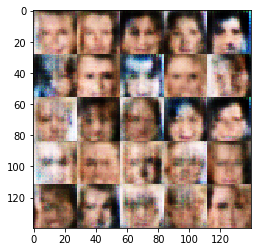

Iteration: 910, d_loss_=1.56855, g_loss_=0.94853
Iteration: 920, d_loss_=1.54352, g_loss_=0.84121
Iteration: 930, d_loss_=1.41545, g_loss_=0.84452
Iteration: 940, d_loss_=1.51987, g_loss_=0.88893
Iteration: 950, d_loss_=1.46427, g_loss_=0.82918


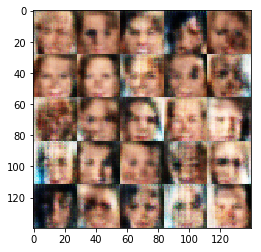

Iteration: 960, d_loss_=1.50415, g_loss_=0.78428
Iteration: 970, d_loss_=1.51009, g_loss_=0.82999
Iteration: 980, d_loss_=1.50252, g_loss_=0.90686
Iteration: 990, d_loss_=1.50011, g_loss_=0.84538
Iteration: 1000, d_loss_=1.47882, g_loss_=0.79207


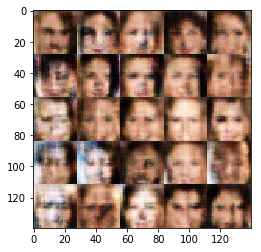

Iteration: 1010, d_loss_=1.49345, g_loss_=0.93006
Iteration: 1020, d_loss_=1.47450, g_loss_=0.83541
Iteration: 1030, d_loss_=1.49293, g_loss_=0.77560
Iteration: 1040, d_loss_=1.46617, g_loss_=0.84549
Iteration: 1050, d_loss_=1.46459, g_loss_=0.86261


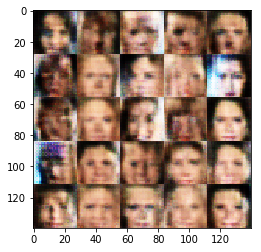

Iteration: 1060, d_loss_=1.46871, g_loss_=0.79862
Iteration: 1070, d_loss_=1.45134, g_loss_=0.99180
Iteration: 1080, d_loss_=1.41683, g_loss_=0.78489
Iteration: 1090, d_loss_=1.47318, g_loss_=0.82557
Iteration: 1100, d_loss_=1.45581, g_loss_=0.91011


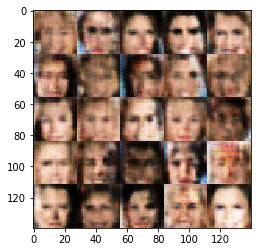

Iteration: 1110, d_loss_=1.43691, g_loss_=0.87271
Iteration: 1120, d_loss_=1.43987, g_loss_=0.84974
Iteration: 1130, d_loss_=1.44450, g_loss_=0.90197
Iteration: 1140, d_loss_=1.44699, g_loss_=0.86170
Iteration: 1150, d_loss_=1.40447, g_loss_=0.91246


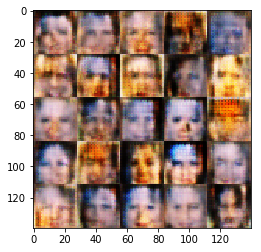

Iteration: 1160, d_loss_=1.43945, g_loss_=0.84833
Iteration: 1170, d_loss_=1.39668, g_loss_=0.81237
Iteration: 1180, d_loss_=1.45085, g_loss_=0.87740
Iteration: 1190, d_loss_=1.48547, g_loss_=0.83945
Iteration: 1200, d_loss_=1.43989, g_loss_=0.87030


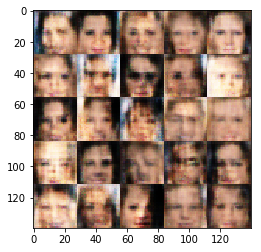

Iteration: 1210, d_loss_=1.44248, g_loss_=0.85655
Iteration: 1220, d_loss_=1.41221, g_loss_=0.84565
Iteration: 1230, d_loss_=1.49744, g_loss_=0.81053
Iteration: 1240, d_loss_=1.36776, g_loss_=0.87378
Iteration: 1250, d_loss_=1.52073, g_loss_=0.79682


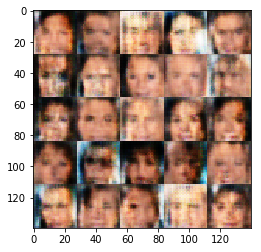

Iteration: 1260, d_loss_=1.39500, g_loss_=0.77112
Iteration: 1270, d_loss_=1.38056, g_loss_=0.88878
Iteration: 1280, d_loss_=1.46159, g_loss_=0.86675
Iteration: 1290, d_loss_=1.43525, g_loss_=0.91567
Iteration: 1300, d_loss_=1.39591, g_loss_=0.82624


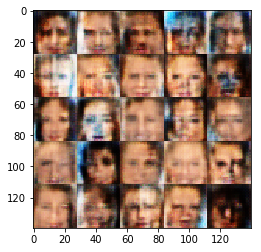

Iteration: 1310, d_loss_=1.42682, g_loss_=0.85922
Iteration: 1320, d_loss_=1.41808, g_loss_=0.90200
Iteration: 1330, d_loss_=1.44922, g_loss_=0.76052
Iteration: 1340, d_loss_=1.46491, g_loss_=0.84664
Iteration: 1350, d_loss_=1.43872, g_loss_=0.83456


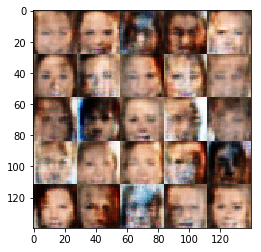

Iteration: 1360, d_loss_=1.43303, g_loss_=0.85740
Iteration: 1370, d_loss_=1.43853, g_loss_=0.73240
Iteration: 1380, d_loss_=1.45012, g_loss_=0.83642
Iteration: 1390, d_loss_=1.41031, g_loss_=0.80244
Iteration: 1400, d_loss_=1.45755, g_loss_=0.89990


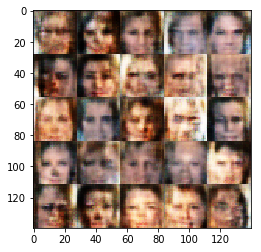

Iteration: 1410, d_loss_=1.43974, g_loss_=0.80008
Iteration: 1420, d_loss_=1.42187, g_loss_=0.89488
Iteration: 1430, d_loss_=1.51306, g_loss_=0.84178
Iteration: 1440, d_loss_=1.50254, g_loss_=0.80320
Iteration: 1450, d_loss_=1.46221, g_loss_=0.78643


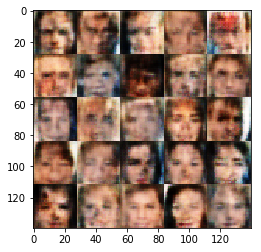

Iteration: 1460, d_loss_=1.44585, g_loss_=0.86611
Iteration: 1470, d_loss_=1.40140, g_loss_=0.80062
Iteration: 1480, d_loss_=1.45470, g_loss_=0.86384
Iteration: 1490, d_loss_=1.41422, g_loss_=0.85353
Iteration: 1500, d_loss_=1.43142, g_loss_=0.84457


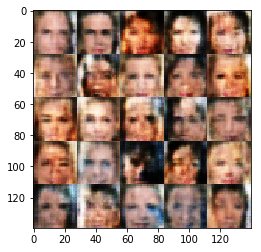

Iteration: 1510, d_loss_=1.47735, g_loss_=0.88117
Iteration: 1520, d_loss_=1.49776, g_loss_=0.84254
Iteration: 1530, d_loss_=1.41112, g_loss_=0.78699
Iteration: 1540, d_loss_=1.46948, g_loss_=0.73355
Iteration: 1550, d_loss_=1.41738, g_loss_=0.87935


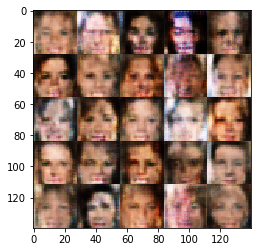

Iteration: 1560, d_loss_=1.48371, g_loss_=0.83712
Iteration: 1570, d_loss_=1.45559, g_loss_=0.80728
Iteration: 1580, d_loss_=1.41244, g_loss_=0.86017


In [45]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。